# Forecasting using spatio-temporal and weather with combined Graph Convolution + LSTM model (multivariate approach)

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from libpysal.weights import Queen

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


import stellargraph_ad_hoc as sg

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from numpy.random import seed
seed(1)

In [3]:
data_path = os.path.join('/','home','fterroso','data','Spain-INE-mobility-study-2020')

## Loading and preprocessing the data

### Trips data

In [4]:
trips_data = pd.read_csv(os.path.join('data','trips_time_series_all_inter.csv'),index_col=0)
trips_data= trips_data.fillna(0)

In [5]:
trips_data.shape

(2844, 6815)

In [6]:
target_areas = trips_data.index.tolist()

In [7]:
trips_data.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_14,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23
01001_AM,291.654,129.650,123.822,280.810,282.418,518.179,736.074,1253.000,981.544,893.510,...,1307.238,1026.083,1073.847,1147.206,650.740,648.024,563.314,735.201,258.461,230.591
01002,192.529,149.992,50.547,73.097,208.114,616.786,732.075,779.587,638.112,734.767,...,701.593,598.760,615.822,826.882,580.843,378.512,381.695,407.566,124.729,106.744
01010_AM,92.726,50.822,37.895,19.586,91.560,396.531,457.180,591.326,516.919,471.008,...,495.460,610.121,559.796,476.880,354.807,215.711,216.593,277.574,119.830,52.331
01031_AM,97.674,64.901,92.150,62.669,109.056,208.462,469.924,691.565,645.793,789.906,...,1085.613,628.526,682.578,582.456,603.958,344.157,286.541,269.655,159.443,118.029
01036,173.565,118.227,204.784,219.318,409.485,779.103,1091.613,969.506,845.084,875.701,...,1070.542,815.612,681.116,746.917,704.784,413.711,441.988,575.437,319.760,68.968


In [8]:
trips_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2844 entries, 01001_AM to 20903
Columns: 6815 entries, 20200221_00 to 20201130_23
dtypes: float64(6815)
memory usage: 147.9+ MB


In [9]:
trips_mtx = trips_data.values

In [10]:
trips_mtx

array([[291.654, 129.65 , 123.822, ..., 735.201, 258.461, 230.591],
       [192.529, 149.992,  50.547, ..., 407.566, 124.729, 106.744],
       [ 92.726,  50.822,  37.895, ..., 277.574, 119.83 ,  52.331],
       ...,
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,   9.76 ,  11.84 ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ]])

In [11]:
trips_mtx.shape

(2844, 6815)

### Weather data

In [12]:
#weather_data = trips_data.copy()
#weather_data = weather_data +1

In [13]:
weather_data = pd.read_csv(os.path.join('data', 'weather_airports', 'weather_time_series_all.csv'), index_col=0)

In [14]:
weather_data.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_14,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23
ID,,,,,,,,,,,,,,,,,,,,,
2408910,4.5,4.0,1.0,2.0,1.0,0.0,-1.5,-2.0,-3.5,2.0,...,11.500000,12.0,13.0,12.5,5.5,1.5,3.0,4.5,4.0,1.5
22117_AM,4.0,4.5,6.0,4.0,2.5,2.0,1.0,0.0,1.5,4.5,...,8.333333,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0
2305009,8.0,7.0,6.5,6.0,5.5,5.0,3.5,3.5,3.0,5.5,...,17.000000,18.0,17.5,17.5,15.0,13.0,10.0,9.0,8.5,8.0
07058_AM,7.0,7.0,7.0,7.0,6.5,6.0,6.0,6.0,6.5,10.0,...,19.000000,19.0,18.0,16.5,15.0,13.5,12.5,12.0,12.0,11.0
2305006,8.0,7.0,6.5,6.0,5.5,5.0,3.5,3.5,3.0,5.5,...,17.000000,18.0,17.5,17.5,15.0,13.0,10.0,9.0,8.5,8.0


In [15]:
weather_data = weather_data.loc[trips_data.index,trips_data.columns]

In [16]:
weather_data.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_14,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23
01001_AM,3.0,2.0,0.5,-1.0,0.0,1.5,2.5,3.0,4.0,4.5,...,5.0,5.5,6.0,5.5,4.5,4.0,8.0,7.5,7.0,5.5
01002,5.5,6.5,7.0,7.5,8.0,8.0,8.5,8.0,9.0,9.5,...,12.0,12.0,13.0,13.0,13.5,12.0,10.5,9.0,8.5,9.0
01010_AM,5.5,6.5,7.0,7.5,8.0,8.0,8.5,8.0,9.0,9.5,...,12.0,12.0,13.0,13.0,13.5,12.0,10.5,9.0,8.5,9.0
01031_AM,3.0,2.0,0.5,-1.0,0.0,1.5,2.5,3.0,4.0,4.5,...,5.0,5.5,6.0,5.5,4.5,4.0,8.0,7.5,7.0,5.5
01036,5.5,6.5,7.0,7.5,8.0,8.0,8.5,8.0,9.0,9.5,...,12.0,12.0,13.0,13.0,13.5,12.0,10.5,9.0,8.5,9.0


In [17]:
weather_mean = weather_data.mean()
weather_data = weather_data.fillna(weather_mean)

In [18]:
weather_data.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_14,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23
01001_AM,3.0,2.0,0.5,-1.0,0.0,1.5,2.5,3.0,4.0,4.5,...,5.0,5.5,6.0,5.5,4.5,4.0,8.0,7.5,7.0,5.5
01002,5.5,6.5,7.0,7.5,8.0,8.0,8.5,8.0,9.0,9.5,...,12.0,12.0,13.0,13.0,13.5,12.0,10.5,9.0,8.5,9.0
01010_AM,5.5,6.5,7.0,7.5,8.0,8.0,8.5,8.0,9.0,9.5,...,12.0,12.0,13.0,13.0,13.5,12.0,10.5,9.0,8.5,9.0
01031_AM,3.0,2.0,0.5,-1.0,0.0,1.5,2.5,3.0,4.0,4.5,...,5.0,5.5,6.0,5.5,4.5,4.0,8.0,7.5,7.0,5.5
01036,5.5,6.5,7.0,7.5,8.0,8.0,8.5,8.0,9.0,9.5,...,12.0,12.0,13.0,13.0,13.5,12.0,10.5,9.0,8.5,9.0


In [19]:
weather_data.tail()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_14,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23
38013_AM,17.0,17.0,17.0,16.5,16.0,16.0,16.0,15.0,15.5,18.0,...,21.000000,21.500000,20.500000,20.500000,19.500000,18.500000,18.000000,18.000000,18.000000,18.000000
05220_AM,0.5,0.0,0.0,0.5,0.0,0.0,-1.5,-2.5,-3.0,0.0,...,13.500000,13.000000,12.000000,11.000000,8.500000,7.000000,6.000000,4.500000,3.500000,2.000000
40149_AM,9.0,11.0,13.0,14.0,15.0,15.0,16.0,17.0,17.0,17.0,...,15.145435,15.463174,15.403283,14.536643,13.055383,11.810008,11.108134,10.454133,9.845933,9.306222
31092_AM,6.5,5.5,4.0,3.0,2.5,2.0,1.0,1.0,2.0,5.0,...,9.000000,11.500000,12.000000,11.000000,11.000000,10.000000,9.000000,8.000000,8.000000,7.500000
20903,8.0,8.0,8.5,9.0,9.0,9.0,9.0,9.5,9.0,10.0,...,13.000000,13.000000,13.000000,13.000000,12.500000,12.000000,11.500000,10.500000,10.000000,9.500000


Number of nan values in the dataframe

In [20]:
weather_data.isnull().sum().sum()

0

In [21]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2844 entries, 01001_AM to 20903
Columns: 6815 entries, 20200221_00 to 20201130_23
dtypes: float64(6815)
memory usage: 147.9+ MB


### Zones data

In [22]:
zones_gdf = gpd.read_file(os.path.join(data_path,'zonificacion','distritos_mitma.shp'))

In [23]:
zones_gdf = zones_gdf[zones_gdf['ID'].isin(target_areas)]

In [24]:
zones_gdf.head()

,ID,geometry
0,2408910,"POLYGON ((290940.137 4719080.203, 290956.704 4..."
1,22117_AM,"POLYGON ((774184.362 4662152.523, 774452.348 4..."
2,2305009,"POLYGON ((429744.982 4179976.538, 429716.997 4..."
3,07058_AM,"POLYGON ((1000859.396 4415059.160, 1000625.088..."
4,2305006,"POLYGON ((429795.125 4180956.539, 429860.816 4..."


In [25]:
zones_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2844 entries, 0 to 2849
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        2844 non-null   object  
 1   geometry  2844 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 66.7+ KB


## Define adjacency/distance matrix

In [26]:
def get_adj_matrix_fn(type_):
    matrix_ = None
    if type_=='distance':
        matrix_ = pd.read_csv(os.path.join('data', 'distances.csv'), index_col=0)
        matrix_ = matrix_.loc[target_areas][target_areas].values
    elif type_ =='contiguity': #contiguity matrix
        qW = Queen.from_dataframe(zones_gdf)
        matrix_ = 1- qW.full()[0]
    elif type_ == 'gravity_model':
        matrix_ = pd.read_csv(os.path.join('data', 'gravity_model_adjacency_matrix.csv'), index_col=0)
        matrix_ = matrix_.replace(0,1)
        matrix_ = matrix_.loc[target_areas][target_areas].values
        np.fill_diagonal(matrix_,0)
    elif type_== 'ylag':
        matrix_ = pd.read_csv(os.path.join('data', 'ylag_adjacency_matrix.csv'), index_col=0)
        matrix_ = matrix_.loc[target_areas][target_areas].values
    elif type_== 'queen_gravity_model':
        matrix_ = pd.read_csv(os.path.join('data', 'queen_gravity_model_adjacency_matrix.csv'), index_col=0)
        matrix_ = matrix_.loc[target_areas][target_areas].values

    return matrix_

In [27]:
matrix_type= 'gravity_model' #or 'distance', 'gravity_model', 'contiguity', 'ylag', 'queen_gravity_model'

In [28]:
adj_matrix = get_adj_matrix_fn(matrix_type)

In [29]:
adj_matrix.shape

(2844, 2844)

In [30]:
#speed_data, sensor_dist_adj = dataset.load()
num_nodes, time_len = trips_data.shape
print("No. of areas:", num_nodes, "\nNo of timesteps:", time_len)

No. of areas: 2844 
No of timesteps: 6815


**Merge trips and weather data.**

In [31]:
def scale_data(raw_data):
    max_value = raw_data.max()
    min_value = raw_data.min()
    data_scaled = (raw_data - min_value) / (max_value - min_value)
    return data_scaled

In [32]:
trips_data.values.max()

60237.72499999973

In [33]:
trips_resc_mtx= scale_data(trips_data.values)

In [34]:
trips_resc_mtx

array([[0.00484172, 0.00215231, 0.00205556, ..., 0.01220499, 0.00429068,
        0.00382802],
       [0.00319615, 0.00249   , 0.00083913, ..., 0.00676596, 0.00207061,
        0.00177205],
       [0.00153933, 0.00084369, 0.00062909, ..., 0.00460798, 0.00198928,
        0.00086874],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00016202, 0.00019655,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [35]:
weather_resc_mtx = scale_data(weather_data.values)

In [36]:
weather_resc_mtx.shape

(2844, 6815)

In [37]:
weather_resc_mtx

array([[0.18181818, 0.16161616, 0.13131313, ..., 0.27272727, 0.26262626,
        0.23232323],
       [0.23232323, 0.25252525, 0.26262626, ..., 0.3030303 , 0.29292929,
        0.3030303 ],
       [0.23232323, 0.25252525, 0.26262626, ..., 0.3030303 , 0.29292929,
        0.3030303 ],
       ...,
       [0.3030303 , 0.34343434, 0.38383838, ..., 0.33240674, 0.32011986,
        0.30921661],
       [0.25252525, 0.23232323, 0.2020202 , ..., 0.28282828, 0.28282828,
        0.27272727],
       [0.28282828, 0.28282828, 0.29292929, ..., 0.33333333, 0.32323232,
        0.31313131]])

In [38]:
trips_resc_mtx.shape

(2844, 6815)

In [39]:
trips_weather_mtx = np.stack((trips_resc_mtx, weather_resc_mtx), axis=-1)

In [40]:
trips_weather_mtx.shape

(2844, 6815, 2)

In [41]:
trips_weather_mtx

array([[[4.84171671e-03, 1.81818182e-01],
        [2.15230572e-03, 1.61616162e-01],
        [2.05555572e-03, 1.31313131e-01],
        ...,
        [1.22049928e-02, 2.72727273e-01],
        [4.29068329e-03, 2.62626263e-01],
        [3.82801641e-03, 2.32323232e-01]],

       [[3.19615324e-03, 2.32323232e-01],
        [2.49000107e-03, 2.52525253e-01],
        [8.39125316e-04, 2.62626263e-01],
        ...,
        [6.76595937e-03, 3.03030303e-01],
        [2.07061273e-03, 2.92929293e-01],
        [1.77204567e-03, 3.03030303e-01]],

       [[1.53933436e-03, 2.32323232e-01],
        [8.43690561e-04, 2.52525253e-01],
        [6.29090823e-04, 2.62626263e-01],
        ...,
        [4.60797615e-03, 3.03030303e-01],
        [1.98928495e-03, 2.92929293e-01],
        [8.68741308e-04, 3.03030303e-01]],

       ...,

       [[0.00000000e+00, 3.03030303e-01],
        [0.00000000e+00, 3.43434343e-01],
        [0.00000000e+00, 3.83838384e-01],
        ...,
        [0.00000000e+00, 3.32406736e-01],
     

In [42]:
node_features = sg.IndexedArray(trips_weather_mtx, index=trips_data.index)

#node_features = sg.IndexedArray(trips_resc_mtx, index=trips_data.index)

In [43]:
graph = sg.StellarGraph(node_features)

### Forecasting with spatio-temporal data as a supervised learning problem 

### Train/test split and sequence preparation for LSTM
* Each training observation are `seq_len` historical outgoing trips.
* Each training prediction is the number of outgoing trips `pre_len` hour later.

In [44]:
train_rate = 0.9
seq_len = 12
pre_len = 12

In [45]:
train_size=int(trips_data.shape[1]*0.9)

In [46]:
generator = sg.mapper.SlidingFeaturesNodeGenerator(graph, seq_len, batch_size=32)
train_gen = generator.flow(slice(0, train_size), target_distance=pre_len)
test_gen = generator.flow(slice(train_size, None), target_distance=pre_len)

In [47]:
generator.window_size

12

In [48]:
generator.variates

2

In [49]:
print("Train data size: ", train_size)
print("Test data size: ", trips_data.shape[1]-train_size)

Train data size:  6133
Test data size:  682


## StellarGraph Graph Convolution and LSTM model

In [50]:
from stellargraph_ad_hoc.layer import GCN_LSTM

In [51]:
gcn_lstm = GCN_LSTM(
    seq_len=None,
    adj=adj_matrix,
    gc_layer_sizes=[256],#, 128],# 64],
    gc_activations=["relu"],#"relu"],# "relu"],#"relu", "relu", "relu", "relu"],#, "relu", "relu"],
    lstm_layer_sizes=[300],# 300],# 300],# 200, 100],#300, 300],
    lstm_activations=["tanh"], # "tanh"], #"tanh"],#"tanh","tanh"],#"tanh", "tanh"],
    generator=generator
)

/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


In [52]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [53]:
model = Model(inputs=x_input, outputs=x_output)

In [54]:
import keras.backend as kbn

Using TensorFlow backend.


In [55]:
#MAE only for the trips measurements (temperature is not considered)
def mean_absolute_error_fn(y_true, y_pred):
    #tf.print(y_pred.shape, y_true[:,:,0])
    #tf.print(y_pred[:,:,0].shape, y_true[:,:,0].shape)
    #tf.print(y_true)
    #tf.print("----")
    #tf.print(y_true[:,:,0])
    #tf.print(y_pred[:,:,0])
    return kbn.mean(kbn.abs(y_true[:,:,0]- y_pred[:,:,0]))

def mean_squared_error_fn(y_true, y_pred):
    return kbn.mean(kbn.square(y_true[:,:,0] - y_pred[:,:,0]))

def mean_root_square_error(y_true, y_pred):
    return kbn.sqrt(kbn.mean(kbn.square(y_pred[:,:,0] - y_true[:,:,0])))

In [56]:
#model.compile(optimizer="adam", loss=mean_absolute_error_fn, metrics=[mean_squared_error_fn])#, mean_absolute_error_fn,mean_root_square_error])
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [57]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(
    train_gen,
    epochs=200,
    batch_size=32,
    shuffle=True,
    validation_data=test_gen,
    callbacks=[es]
)

Epoch 1/200
191/191 [==============================] - 1063s 6s/step - loss: 0.1074 - mse: 0.0285 - val_loss: 0.0692 - val_mse: 0.0123
Epoch 2/200
191/191 [==============================] - 1022s 5s/step - loss: 0.0675 - mse: 0.0128 - val_loss: 0.0505 - val_mse: 0.0066
Epoch 3/200
191/191 [==============================] - 1017s 5s/step - loss: 0.0625 - mse: 0.0111 - val_loss: 0.0446 - val_mse: 0.0053
Epoch 4/200
191/191 [==============================] - 1018s 5s/step - loss: 0.0671 - mse: 0.0128 - val_loss: 0.0710 - val_mse: 0.0121
Epoch 5/200
191/191 [==============================] - 1023s 5s/step - loss: 0.0567 - mse: 0.0088 - val_loss: 0.0407 - val_mse: 0.0043
Epoch 6/200
191/191 [==============================] - 1032s 5s/step - loss: 0.0384 - mse: 0.0039 - val_loss: 0.0313 - val_mse: 0.0024
Epoch 7/200
191/191 [==============================] - 1031s 5s/step - loss: 0.0368 - mse: 0.0037 - val_loss: 0.0317 - val_mse: 0.0026
Epoch 8/200
191/191 [==============================] - 

In [58]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2844, 12, 2)]     0         
_________________________________________________________________
reshape (Reshape)            (None, 2844, 24)          0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 2844, 512)         8103468   
_________________________________________________________________
reshape_1 (Reshape)          (None, 2844, 256, 2)      0         
_________________________________________________________________
permute (Permute)            (None, 256, 2844, 2)      0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 256, 5688)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               718680

In [59]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.025273054838180542 
Test loss: 0.02589007280766964


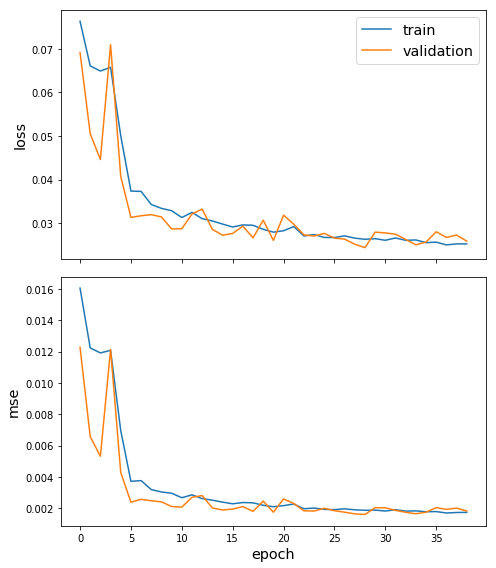

In [60]:
sg.utils.plot_history(history)

In [61]:
yhat = model.predict(test_gen)

In [62]:
yhat

array([[[1.25497282e-02, 4.90507156e-01],
        [6.53761625e-03, 4.99400735e-01],
        [5.34757972e-03, 5.01376688e-01],
        ...,
        [1.40611719e-05, 4.74728942e-01],
        [1.69059634e-03, 5.10692894e-01],
        [1.98564721e-05, 4.90534157e-01]],

       [[1.14650726e-02, 4.83286858e-01],
        [5.65198064e-03, 4.90061373e-01],
        [4.66212630e-03, 4.91972566e-01],
        ...,
        [1.23816335e-05, 4.72678602e-01],
        [1.45232677e-03, 5.03642559e-01],
        [1.75608493e-05, 4.82021958e-01]],

       [[1.12415552e-02, 4.74747390e-01],
        [5.47075272e-03, 4.82468665e-01],
        [4.51356173e-03, 4.84185338e-01],
        ...,
        [1.34567190e-05, 4.67204750e-01],
        [1.37731433e-03, 4.93874937e-01],
        [1.89027614e-05, 4.75144446e-01]],

       ...,

       [[4.62248921e-03, 2.34152526e-01],
        [2.27251649e-03, 2.97927737e-01],
        [1.59275532e-03, 2.95052648e-01],
        ...,
        [2.53680337e-05, 2.64668018e-01],
     

In [63]:
yhat.shape

(659, 2844, 2)

In [64]:
yhat.T.shape

(2, 2844, 659)

In [65]:
yhat= yhat.T[0]

In [66]:
yhat.shape

(2844, 659)

## Rescale values

Rescale the predicted values to the original value range of the timeseries.

In [67]:
## Rescale values
max_speed = trips_data.values.max()

## actual test values
test_rescref = trips_resc_mtx[:,train_size+12+pre_len-1:] * max_speed

In [68]:
test_rescref

array([[ 920.595,  942.116, 1019.219, ...,  735.201,  258.461,  230.591],
       [ 764.158, 1131.461,  492.119, ...,  407.566,  124.729,  106.744],
       [ 490.639,  556.077,  409.794, ...,  277.574,  119.83 ,   52.331],
       ...,
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [ 136.181,  171.561,  247.85 , ...,    9.76 ,   11.84 ,    0.   ],
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ]])

In [69]:
test_rescref.shape

(2844, 659)

In [70]:
## Rescale model predicted values
test_rescpred = np.array(yhat * max_speed)

In [71]:
test_rescpred

array([[7.5596710e+02, 6.9062988e+02, 6.7716571e+02, ..., 2.7844824e+02,
        2.0512770e+02, 1.7513489e+02],
       [3.9381113e+02, 3.4046246e+02, 3.2954572e+02, ..., 1.3689122e+02,
        9.8301086e+01, 8.3294807e+01],
       [3.2212604e+02, 2.8083588e+02, 2.7188669e+02, ..., 9.5943962e+01,
        6.7180878e+01, 5.6194107e+01],
       ...,
       [8.4701306e-01, 7.4584144e-01, 8.1060219e-01, ..., 1.5281126e+00,
        9.9143404e-01, 7.8381032e-01],
       [1.0183768e+02, 8.7484863e+01, 8.2966286e+01, ..., 5.2916055e+00,
        3.3260117e+00, 2.6473110e+00],
       [1.1961087e+00, 1.0578257e+00, 1.1386594e+00, ..., 1.6071122e+00,
        1.0532726e+00, 8.3889049e-01]], dtype=float32)

In [72]:
test_rescpred.shape

(2844, 659)

In [73]:
test_rescpred[2000]

array([596.94257 , 542.76984 , 526.1802  , 521.62213 , 545.20776 ,
       571.18823 , 629.88135 , 547.3369  , 373.44434 , 209.69833 ,
       119.953285,  80.89101 ,  68.39086 ,  67.30475 ,  69.98861 ,
        83.33969 , 101.704834, 125.18816 , 156.28683 , 206.22458 ,
       338.69955 , 474.7506  , 527.8157  , 545.30115 , 550.3511  ,
       547.4428  , 562.5604  , 558.6486  , 580.96326 , 565.1689  ,
       555.3885  , 440.37567 , 277.17365 , 171.83527 , 119.38241 ,
        91.762886,  76.09596 ,  70.24532 ,  67.79125 ,  77.058205,
        93.89741 , 114.69867 , 141.09923 , 172.99678 , 251.80891 ,
       384.7686  , 528.7312  , 626.4345  , 648.7437  , 605.22034 ,
       577.4482  , 554.3903  , 547.19507 , 498.7366  , 451.8328  ,
       365.60815 , 251.72812 , 157.55426 , 108.39922 ,  78.43873 ,
        68.36393 ,  67.0211  ,  69.30822 ,  77.51598 ,  94.371346,
       121.77185 , 153.48268 , 192.12129 , 275.8649  , 375.74402 ,
       446.35916 , 478.42545 , 468.91254 , 457.091   , 478.114

## Measuring the performance of the model

### Naive prediction benchmark (using latest observed value)

In [74]:
trips_weather_mtx.shape

(2844, 6815, 2)

In [75]:
# picking the last outgoing trips of the 12 sequence for each MA in each sample
testnpred = trips_weather_mtx[:,train_size+11:-1,0]  
testnpredc = testnpred * max_speed

In [76]:
testnpredc

array([[164.504, 114.116, 184.678, ..., 563.314, 735.201, 258.461],
       [172.126, 126.635,  90.222, ..., 381.695, 407.566, 124.729],
       [ 43.377,  70.257, 108.454, ..., 216.593, 277.574, 119.83 ],
       ...,
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ],
       [ 65.215,   0.   ,  13.482, ...,  64.342,   9.76 ,  11.84 ],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ]])

In [77]:
test_rescref

array([[ 920.595,  942.116, 1019.219, ...,  735.201,  258.461,  230.591],
       [ 764.158, 1131.461,  492.119, ...,  407.566,  124.729,  106.744],
       [ 490.639,  556.077,  409.794, ...,  277.574,  119.83 ,   52.331],
       ...,
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [ 136.181,  171.561,  247.85 , ...,    9.76 ,   11.84 ,    0.   ],
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ]])

In [78]:
test_rescref.shape

(2844, 659)

In [79]:
test_metrics = []

for j in range(trips_data.shape[0]):
    gnn_mae_ = mean_absolute_error(test_rescref[j], test_rescpred[j])
    gnn_mse_ = mean_squared_error(test_rescref[j], test_rescpred[j])
    gnn_rmse_ = mean_squared_error(test_rescref[j], test_rescpred[j], squared = False)
    
    
    test_metrics.append((trips_data.iloc[j].name, gnn_mae_, gnn_mse_, gnn_rmse_))

In [80]:
test_metrics_df = pd.DataFrame.from_records(test_metrics, 
                                            columns='area_id gnn-MAE gnn-MSE gnn-RMSE'.split())

In [81]:
test_metrics_df.head()

,area_id,gnn-MAE,gnn-MSE,gnn-RMSE
0,01001_AM,196.310588,88964.641499,298.269411
1,01002,146.952559,43622.854943,208.860851
2,01010_AM,128.112745,34606.534015,186.028315
3,01031_AM,143.330923,38201.037386,195.450857
4,01036,207.606053,79677.448332,282.271940


In [82]:
test_metrics_df.mean()

gnn-MAE        300.965945
gnn-MSE     427649.183233
gnn-RMSE       416.326082
dtype: float64

In [83]:
test_metrics_df.to_csv(os.path.join('data', 'gnn_naive_test_metrics_{}_{}_multivariate.csv'.format(matrix_type, pre_len)))

In [84]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(trips_data.shape[0]):

    seg_mael.append(
        np.mean(np.abs(test_rescref[j] - test_rescpred[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref[j] - testnpredc[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

ValueError: operands could not be broadcast together with shapes (659,) (670,) 

In [ ]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

#### Plot of actual and predicted outgoing trips on a sample MA

In [ ]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 20]
a_true = test_rescref[:, 20]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("Num.of trips")
plt.legend(loc="best", fontsize=10)
plt.show()

#### Plot of actual and predicted outgoing trips from Spain

In [ ]:
test_rescpred_df =pd.DataFrame(test_rescpred).T
test_rescref_df =pd.DataFrame(test_rescref).T

In [ ]:
test_rescpred_df.loc['total']= test_rescpred_df.sum(axis=0)
test_rescref_df.loc['total']= test_rescref_df.sum(axis=0)

In [ ]:
test_rescpred_df.tail(3)

In [ ]:
test_rescref_df.tail(3)

In [ ]:
ax=test_rescpred_df.loc['total'].plot(figsize=(20,5), label='Predicted')
test_rescref_df.loc['total'].plot(ax=ax, grid=True, label='Reference')
ax.set_ylabel('Number of trips')
ax.set_xlabel('Time (h)')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.legend(loc='lower left');
plt.savefig(os.path.join('figs',f'true_vs_predicted_global_{pre_len}_multivariate.png'))

In [ ]:
print("That's all folks")